In [226]:
from utilities import tirage_al, list_geom
from utilities_2 import *
from math import floor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from generation_pop import generer_pop
from tqdm import tqdm


def to_int(L):
    '''Renvoie la même liste mais avec des éléments de type 'int'.
    Renvoie une erreur si la conversion est impossible'''
    return [int(i) for i in L]


sal_etat = pd.read_csv('grilles_salariales/corr_salaires_etat.csv', sep=',')
sal_terr = pd.read_csv('grilles_salariales/corr_salaires_terr.csv', sep=',')
sal_hosp = pd.read_csv('grilles_salariales/corr_salaires_hosp.csv', sep=',')



## Génération des fonctionnaires

In [227]:
##Population de fonctionnaires

Nbr_fonct = 2000
point = 4.686025 #Valeur du point

pop = generer_pop(Nbr_fonct)

#Transformation fonctionnaire --> Data frame

fonct = np.array(pop)


dict_fonct = {}
dict_fonct['Versant'] = fonct[:,0]
dict_fonct['Cat'] = fonct[:,1]
dict_fonct['IM'] = fonct[:,2]
dict_fonct['arret_maladie'] = fonct[:,3]
dict_fonct['age'] = fonct[:,4]
dict_fonct['enfants'] = fonct[:,5]
dict_fonct['zone_geo'] = fonct[:,6]
dict_fonct['NBI'] = fonct[:,7]

df_fonct = pd.DataFrame(dict_fonct)
df_bis = df_fonct.copy()
df_fonct

Versant  Cat     IM  arret_maladie   age  enfants  zone_geo   NBI
0         1.0  1.0  551.0           11.5  40.0      0.0       1.0  33.0
1         1.0  3.0  566.0            0.0  50.0      1.0       2.0  12.0
2         2.0  3.0  382.0            0.0  37.0      1.0       2.0  18.0
3         2.0  3.0  377.0            0.0  32.0      0.0       3.0  10.0
4         1.0  3.0  470.0            0.0  44.0      2.0       3.0  10.0
...       ...  ...    ...            ...   ...      ...       ...   ...
1995      1.0  2.0  509.0            0.0  57.0      1.0       1.0  10.0
1996      1.0  2.0  466.0            0.0  39.0      3.0       1.0  13.0
1997      2.0  1.0  535.0            4.0  55.0      0.0       3.0  39.0
1998      1.0  2.0  397.0            0.0  53.0      0.0       2.0  21.0
1999      1.0  1.0  344.0            0.0  37.0      3.0       1.0  38.0

[2000 rows x 8 columns]

### On affecte à chaque fonctionnaire un métier

In [228]:
metier = []
versant = []
cat = []
IM_list = []
grade_list = []
echelon_list = []
anciennete_grade = []

for i in range(Nbr_fonct):
    Versant_i = df_fonct['Versant'].iloc[i]
    Cat_i = df_fonct['Cat'].iloc[i]
    #Redéfinition de la catégorie
    if Cat_i == 1:
        Cat_i = 'A'
    if Cat_i == 2:
        Cat_i = 'B'
    if Cat_i == 3:
        Cat_i = 'C'
    bool = False
    #Redéfinition du versant de la fonction publique.
    if Versant_i == 1:
        df = sal_etat
        versant.append('Etat')
    if Versant_i == 2:
        df = sal_terr
        versant.append('Territoriale')
    if Versant_i == 3:
        df = sal_hosp
        versant.append('Hospitalière')
    
    IM_i = df_fonct['IM'].iloc[i]
    age = df_fonct['age'].iloc[i]

    #Métiers possibles

    choix = df.loc[df['cat'] == Cat_i]
    liste = choix['fonction'].unique()
    met = np.random.choice(liste)
    metier.append(met)

    #Selection du grade, de l'échelon et de l'indice majoré

    IM_min = (choix.loc[choix['fonction'] == met]['indice majoré calculé']).min()
    # print(IM_min)
    if IM_i <= IM_min: #Si l'IM minimal est plus grand que l'IM généré, on conserve l'indice minimal.
        IM = IM_min
        # print(choix.loc[choix['fonction']==met].loc[choix['indice majoré calculé'] == IM_min])
        # print('liste1 : ', list(choix.loc[choix['fonction']==met].loc[choix['indice majoré calculé'] == IM_min]['grade']))
        grade = list(choix.loc[choix['fonction']==met].loc[choix['indice majoré calculé'] == IM_min]['grade']).pop()
        echelon = list(choix.loc[choix['fonction']==met].loc[choix['indice majoré calculé'] == IM_min]['Echelon']).pop()
    else :
        if df_fonct['age'].iloc[i] <= 27 :#Jeunes agents : toujours le grade le moins rémunérateur
            grade = df.loc[df['fonction'] == met,'grade'].max()
        else :
            nbr_grade = choix.loc[choix['fonction'] == met]['grade'].max()
            bool = True
                
            p = (nbr_grade-1-floor((age - 21)/16))/(nbr_grade+1) #paramètre d'une loi binomiale (nombre de grade, p) contruit de sorte que 
            # plus on est en fin de carrière, plus le grade sera élevé.
            grades_possible = list_binom(p, nbr_grade)
            grade = tirage_al(grades_possible)+1
            

        grille = choix.loc[choix['fonction']==met].loc[choix['grade']==grade][['indice majoré calculé', 'Echelon']]
        grille_diff = [i for i in grille['indice majoré calculé']-IM_i if i>=0]
        if len(grille_diff) == 0:
            IM = grille['indice majoré calculé'].max()
            echelon = grille['Echelon'].max()
        else :
            IM = np.min(grille_diff) + IM_i
            echelon = list(grille.loc[grille['indice majoré calculé'] == IM]['Echelon']).pop()

    # Ancienneté aléatoire --> modèle un peu plus élaboré ?

    anc = np.random.randint(0,5)

    anciennete_grade.append(anc)
    grade_list.append(grade)
    grade = to_int(grade_list)
    IM_list.append(IM)
    IM_list = to_int(IM_list)
    echelon_list.append(echelon)
    echelon_list = to_int(echelon_list)
    cat.append(Cat_i)



### Calcul des primes

In [229]:
prime_lst = []
jour_moyen_abs = df_fonct['arret_maladie'].mean()
age_retraite = 65
age_depart_car = 23 #arbitraire : age de démarrage de la carrière en moyenne

z = (age_retraite - df_fonct['age'] + age_depart_car)/age_retraite 
y = df_fonct['arret_maladie'] / jour_moyen_abs

x = np.array(5*(z + y) /2)

for i in range(Nbr_fonct):
    Cat_i = df_fonct['Cat'].iloc[i]

    if int(Cat_i) == 1: #Catégorie A
        IFSE = 3194 * 12
        CIA_max = 5750
    if int(Cat_i) == 2: #Catégorie B
        IFSE = 1253 * 12 
        CIA_max = 1804
    if int(Cat_i) == 3: #Catégorie C
        IFSE = 978 * 12 
        CIA_max = 1174

    prime = round(IFSE + CIA_max *(np.exp(-x[i])),2)
    prime_lst.append(prime)

In [230]:
df_fonct['fonction'] = metier
df_fonct['Versant'] = versant
df_fonct['Cat'] = cat
df_fonct['IM'] = IM_list
df_fonct['grade'] = grade_list
df_fonct['echelon'] = echelon_list
df_fonct['anc_echelon'] = anciennete_grade
df_fonct['prime'] = prime_lst


In [231]:
df_fonct.head()

Versant Cat   IM  arret_maladie   age  enfants  zone_geo   NBI  \
0          Etat   A  575           11.5  40.0      0.0       1.0  33.0   
1          Etat   C  420            0.0  50.0      1.0       2.0  12.0   
2  Territoriale   C  392            0.0  37.0      1.0       2.0  18.0   
3  Territoriale   C  380            0.0  32.0      0.0       3.0  10.0   
4          Etat   C  382            0.0  44.0      2.0       3.0  10.0   

                                            fonction  grade  echelon  \
0  Ingénieur d'études du ministère chargé de l'en...      1        1   
1          Adjoint technique du Ministère des Sports      2       12   
2                       Agent social territorial-AST      2        9   
3  Agent de police municipale -APM-(policier  mun...      3        8   
4                        Dessinateur de l'équipement      1       11   

   anc_echelon     prime  
0            3  38331.43  
1            3  12008.23  
2            4  11901.11  
3            0  11872.23  
4            4  11952.13

### Dataframe final

In [232]:
df_fonct = df_fonct[['age', 'Versant', 'Cat', 'grade', 'echelon', 'anc_echelon', 'fonction', 'IM', 'prime', 'arret_maladie', 'enfants', 'zone_geo']]
df_init = df_fonct.copy()
df_fonct

age       Versant Cat  grade  echelon  anc_echelon  \
0     40.0          Etat   A      1        1            3   
1     50.0          Etat   C      2       12            3   
2     37.0  Territoriale   C      2        9            4   
3     32.0  Territoriale   C      3        8            0   
4     44.0          Etat   C      1       11            4   
...    ...           ...  ..    ...      ...          ...   
1995  57.0          Etat   B      1        8            4   
1996  39.0          Etat   B      1        6            0   
1997  55.0  Territoriale   A      1        5            4   
1998  53.0          Etat   B      1        2            4   
1999  37.0          Etat   A      1        1            4   

                                               fonction    IM     prime  \
0     Ingénieur d'études du ministère chargé de l'en...   575  38331.43   
1             Adjoint technique du Ministère des Sports   420  12008.23   
2                          Agent social territorial-AST   392  11901.11   
3     Agent de police municipale -APM-(policier  mun...   380  11872.23   
4                           Dessinateur de l'équipement   382  11952.13   
...                                                 ...   ...       ...   
1995   Secrétaire administratif du Ministère des Sports   534  15583.55   
1996   Secrétaire administratif du ministère des Armées   484  15310.00   
1997                                     Ergothérapeute   558  38560.24   
1998  Technicien du Ministère de la Transition écolo...   404  15505.47   
1999                   Vice-président du Conseil d'Etat  1510  39136.69   

      arret_maladie  enfants  zone_geo  
0              11.5      0.0       1.0  
1               0.0      1.0       2.0  
2               0.0      1.0       2.0  
3               0.0      0.0       3.0  
4               0.0      2.0       3.0  
...             ...      ...       ...  
1995            0.0      1.0       1.0  
1996            0.0      3.0       1.0  
1997            4.0      0.0       3.0  
1998            0.0      0.0       2.0  
1999            0.0      3.0       1.0  

[2000 rows x 12 columns]

In [233]:
#Différence d'indice majoré par rapport à la génération intiale :

IM_base = df_bis['IM']
IM_affecté = df_fonct['IM']

A = np.zeros((IM_base.count(), 2), dtype = int)

A[:,0] = range(IM_base.count())
A[:,1] = IM_base - IM_affecté
print(np.ma.median(abs(A[:,1])))
print(np.mean(A[:,1]))

41.0
-53.02


### Coût global moyen (hors primes) :

In [234]:
cat = 'A'
IM_A = df_fonct.loc[df_fonct['Cat'] == cat]['IM']
primes_A  = df_fonct.loc[df_fonct['Cat']==cat]['prime']
nbr_A = IM_A.size
sal_moy = (IM_A.sum()*point*12 + primes_A.sum())/nbr_A
print(sal_moy)

75427.2815705964


### Coût de sortie


In [235]:
IM_sortie = df_fonct.loc[(df_fonct['Cat'] == cat) & (df_fonct['age'] >= 60)]['IM']
primes_sortie = df_fonct.loc[(df_fonct['Cat'] == cat) & (df_fonct['age'] >= 60)]['prime']
nbr_sortie = IM_sortie.size
sal_moy = (IM_sortie.sum()*point*12 + primes_sortie.sum())/nbr_sortie
print(sal_moy)

79360.18721869159


### Coût d'entrée

In [236]:
IM_entrée = df_fonct.loc[(df_fonct['Cat'] == cat) & (df_fonct['age'] <= 26)]['IM']
primes_entrée = df_fonct.loc[(df_fonct['Cat'] == cat) & (df_fonct['age'] <= 26)]['prime']
nbr_entrée = IM_entrée.size
sal_moy = (IM_entrée.sum()*point*12 + primes_entrée.sum())/nbr_entrée
print(sal_moy)

74066.62929358974


## Évolution des fonctionnaires

In [237]:
def evolve(df_fonct, nbr_annees = 1, taux_promo_grade = 0.1, taux_promo_corps = 0.05):
    
    '''Fonction prenant en argument :
    - un DataFrame avec comme colonnes :
        - anc_echelon : l'ancienneté d'un agent dans son echelon
        - fonction : la dénomination exacte de la fonction d'un agent
        - Versant : son versant de la fonction publique
        - echelon : son echelon actuel
        - grade : son grade actuel
        - IM : son indice majoré actuel
        
    - le nombre d'années d'évolution
    - un taux de promotion représentant la porportion maximale d'agent pouvant augmenter son grade sur une année.

    La fonction modifie le DataFrame df_fonct avec les nouvelles données.

    Pour controler les lignes ayant eu un changement (promotion ou évolution de salaire), on peut utiliser la liste
    'changement', qui pour chaque indice correspond au nombre de changement dans la situation salairale de l'agent (0, 1 ou 2 changements) 
    '''

    Nbr_fonct = df_fonct['fonction'].count() #Nombre de fonctionnaire dans la population

    changement = [0 for i in range(Nbr_fonct)] #Variable de contrôle

    for k in range(nbr_annees):
        for i in range(Nbr_fonct):
            #Variables pour faciliter l'accès à certains paramètres
            agent = df_fonct.iloc[i,:]
            anciennete = agent['anc_echelon']
            fonction = agent['fonction']
            versant = agent['Versant']
            categorie = agent['Cat']
            echelon = agent['echelon']
            grade = agent['grade']
            IM_i = agent['IM']

            #Chargement du dataframe correspondant au bon versant de la fonction publique
 
            if versant == 'Etat' :
                df = sal_etat.copy()
            if versant == 'Hospitalière':
                df = sal_hosp.copy()
            if versant == 'Territoriale':
                df = sal_terr.copy()
            
            df_fonct.iloc[i,0] += 1 #Mise à jour de l'âge
            

            grille = df.loc[df['fonction'] == fonction][['grade', 'Echelon', 'indice majoré calculé', 'durée']] #grille salariale de l'agent pour l'année n-1

            if list(grille.loc[(grille['grade'] == grade) & (grille['Echelon'] == echelon),'durée'])[0] <= anciennete : #Evolution naturelle
                df_fonct.iloc[i,5] = 0 #remise à 0 de l'ancienneté
                
                df_fonct.iloc[i,4] += 1 #Evolution de l'échelon
                
                #Revalorisation de l'IM
                
                df_fonct.iloc[i,7] = list(grille.loc[(grille['grade'] == grade ) & (grille['Echelon'] == df_fonct.iloc[i,4]),'indice majoré calculé']).pop()
                
                changement[i] += 1
            
            else : 
                df_fonct.iloc[i,5] += 1 #Augmentation de l'ancienneté si pas d'évolution d'échelon
                 
            if np.random.random() < taux_promo_grade or df_fonct.iloc[i,5] >= 7: #Promotion de grade de l'agent : passage au grade supérieur
                if grade !=1 : #Promotion de grade
                    df_fonct.iloc[i,3] -= 1 #Mise a jour du grade
                    df_fonct.iloc[i,5] = 0 #remise à 0 de l'ancienneté
                    # Differentiel entre l'IM actuel et les IM du nouveau grade (évolution ne peut se faire que dans le sens d'augmentation de l'IM)
                    grille_diff = [i for i in grille.loc[grille['grade'] == df_fonct.iloc[i,3]]['indice majoré calculé']-df_fonct.iloc[i,7] if i>=0]

                    if len(grille_diff) == 0: #IM du nouveau grade toujours plus faible que l'IM actuel (normalement ce cas n'arrive pas)
                        print('Erreur 1')
                        IM = grille.loc[grille['grade'] == df_fonct.iloc[i,3], 'indice majoré calculé'].max()
                        echelon = grille.loc[grille['grade'] == df_fonct.iloc[i,3], 'Echelon'].max()
                    else : 
                        IM = np.min(grille_diff) + df_fonct.iloc[i,7] #nouvel IM
                        echelon = list(grille.loc[(grille['indice majoré calculé'] == IM) & (grille['grade'] == df_fonct.iloc[i,3]),'Echelon']).pop() #nouvel échelon
                        
                    df_fonct.iloc[i,7] = IM #Mise a jour de l'IM
                    df_fonct.iloc[i,4] = echelon #Mise a jour de l'échelon
                    
                    changement[i] += 1
    
            if np.random.random() < taux_promo_corps or df_fonct.iloc[i,5] >= 10 : #Promotion de corps
                promo = False #Par défaut la promotion n'est pas possible
                if categorie == 'C' : 
                    df_fonct.iloc[i,2] = 'B'
                    promo = True
                if categorie == 'B' :
                    df_fonct.iloc[i,2] = 'A'
                    promo = True
                
                if promo == True :
                    df_fonct.iloc[i,5] = 0 #Remise à 0 de l'ancienneté

                    choix = df.loc[(df['cat'] == df_fonct.iloc[i,2]) & (df['indice majoré calculé'] >= float(df_fonct.iloc[i,7]))] # Promotion uniquement vers un métier plus rémunérateur.
                    
                    liste = choix['fonction'].unique()

                    nouv_met = np.random.choice(liste)
                    df_fonct.iloc[i,6] = nouv_met

                    nouv_grille = df.loc[df['fonction']==nouv_met][['fonction', 'cat','indice majoré calculé', 'Echelon', 'grade']] #grille du nouveau métier
                    
                    IM_min = nouv_grille['indice majoré calculé'].min()

                    if float(df_fonct.iloc[i,7]) <= IM_min: #Si l'IM minimal est plus grand que l'IM actuel
                        nouv_IM = IM_min
                        nouv_grade = list(nouv_grille.loc[nouv_grille['indice majoré calculé'] == IM_min]['grade']).pop()
                        nouv_echelon = list(nouv_grille.loc[nouv_grille['indice majoré calculé'] == IM_min]['Echelon']).pop()       

                    else:
                        nouv_grille_diff = [i for i in nouv_grille['indice majoré calculé']-df_fonct.iloc[i,7] if i>=0]
                        if len(nouv_grille_diff) == 0: # L'indice majoré du nouveau métier n'est jamais meilleur (peu importe l'échelon)
                            # --> normalement ce cas n'arrive jamais
                            print('Erreur 2')
                            nouv_IM = nouv_grille['indice majoré calculé'].max()
                            nouv_echelon = nouv_grille['Echelon'].max()
                            nouv_grade = nouv_grille['grade'].min()
                        else : #On prend l'indice majoré le plus proche par excès
                            nouv_IM = np.min(nouv_grille_diff) + df_fonct.iloc[i,7]
                            nouv_echelon = list(nouv_grille.loc[nouv_grille['indice majoré calculé'] == nouv_IM]['Echelon']).pop()
                            nouv_grade = list(nouv_grille.loc[nouv_grille['indice majoré calculé'] == nouv_IM]['grade']).pop()

                    #Actualisation des informations
                    df_fonct.iloc[i,7] = nouv_IM
                    df_fonct.iloc[i,3] = nouv_grade
                    df_fonct.iloc[i,4] = nouv_echelon


            ## Définition de la prime : 
            z_i = (age_retraite - df_fonct['age'].iloc[i] + age_depart_car)/age_retraite 
            y_i = df_fonct['arret_maladie'].iloc[i] / jour_moyen_abs
            x_i = 5*(z_i + y_i) / 2

            Cat_i = df_fonct.iloc[i,2]

            if Cat_i == 'A':
                IFSE = 3194 * 12
                CIA_max = 5750
            if Cat_i == 'B': 
                IFSE = 1253 * 12 
                CIA_max = 1804
            if Cat_i == 'C': 
                IFSE = 978 * 12 
                CIA_max = 1174
            
            new_prime = round(IFSE + CIA_max * np.exp(-x_i),2)
            
            df_fonct.iloc[i,8] = new_prime


            


In [238]:
def calcul_sal(df_fonct, p):
    '''Fonction qui prend en argument un dataframe avec une colonne 'IM' et une colonne 'prime'
    qui renvoit une colonne donnant le salaire associé (IM*p + prime)'''

    return df_fonct['IM'] * p * 12 + df_fonct['prime']
    

In [239]:
annees = 10
IM_matrix = np.zeros((Nbr_fonct, annees))
prime_matrix = np.zeros((Nbr_fonct, annees))
sal_matrix = np.zeros((Nbr_fonct, annees))
IM_matrix[:,0] = df_fonct['IM']
prime_matrix[:,0] = df_fonct['prime']
sal_matrix[:,0] = calcul_sal(df_fonct, point)
for k in tqdm(range(1,annees)):
    evolve(df_fonct)
    IM_matrix[:,k] = df_fonct['IM']
    prime_matrix[:,k] = df_fonct['prime']
    sal_matrix[:,k] = calcul_sal(df_fonct, point)

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Utilisateur\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
 22%|██▏       | 2/9 [00:14<00:51,  7.42s/it]

Erreur 1
Erreur 1


 33%|███▎      | 3/9 [00:21<00:43,  7.24s/it]

Erreur 1
Erreur 1
Erreur 1


 56%|█████▌    | 5/9 [00:35<00:28,  7.00s/it]

Erreur 1


 67%|██████▋   | 6/9 [00:42<00:20,  6.97s/it]

Erreur 1


 89%|████████▉ | 8/9 [00:57<00:07,  7.14s/it]

Erreur 1
Erreur 1


100%|██████████| 9/9 [01:04<00:00,  7.14s/it]


Technicien supérieur des études et de l'exploitation de l'aviation civile- TSEEAC 
 [38690.2079     38704.18247643 38718.70239954 38733.79165984
 38749.47258148 38765.76836394 42885.8778083  42912.92056261
 42941.02368381 43926.1778497 ]


age Versant Cat  grade  echelon  anc_echelon  \
1200  66.0    Etat   B      1        2            0   

                                               fonction     IM        prime  \
1200  Technicien supérieur des études et de l'exploi...  500.0  15810.02785   

      arret_maladie  enfants  zone_geo  
1200            0.0      1.0       3.0

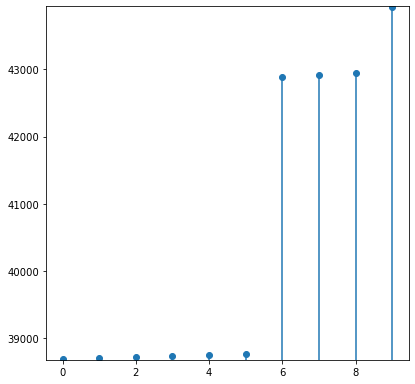

In [240]:
i = 1200
plt.figure(figsize = (6.5,6.5))
plt.stem(sal_matrix[i,:])
plt.ylim(sal_matrix[i,:].min()-10, sal_matrix[i,:].max()+10)
print(df_fonct['fonction'].iloc[i],'\n', sal_matrix[i,:])
df_fonct.iloc[i:i+1,:]


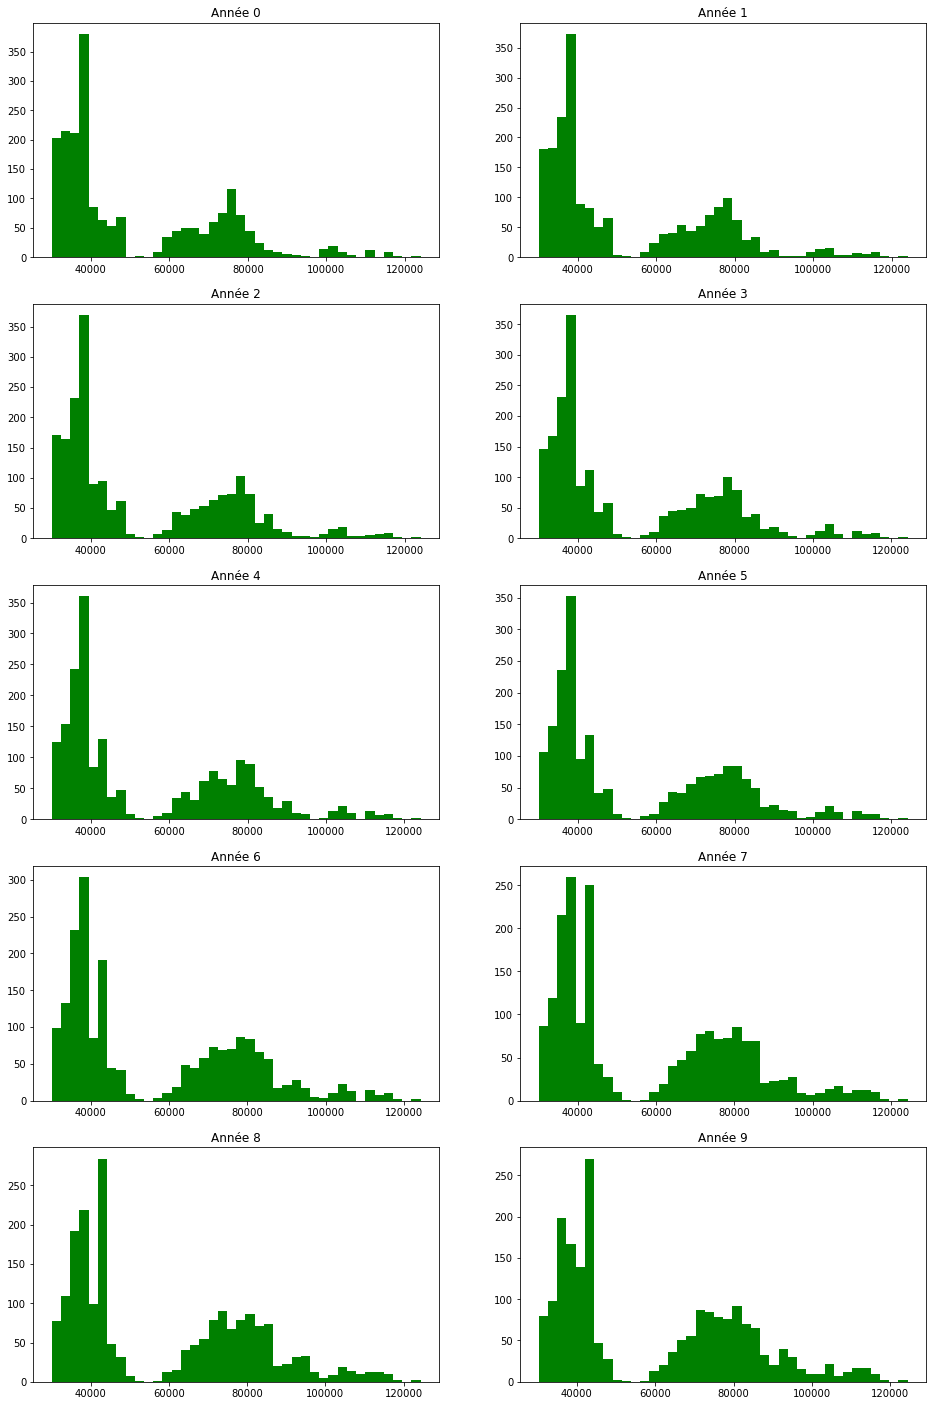

In [242]:
plt.figure(figsize = (16,25))
for i in range(annees):
    plt.subplot(5,2,i+1)
    plt.title('Année ' + str(i))
    plt.hist(sal_matrix[:,i], bins  = 40, color= 'g')